In [1148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image 
from matplotlib import font_manager, rc

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [1039]:
loan_result = pd.read_csv('data/loan_result.csv')
# log_data = pd.read_csv('data/log_Data.csv')
user_spec = pd.read_csv('data/user_spec.csv')

In [1040]:
loan_result.columns=['신청서_번호', '한도조회_일시', '금융사_번호', '상품_번호', '승인한도', '승인금리', '신청_여부(y)']
# log_data.columns=['유저_번호', '행동명', '행동일시', '운영체제', '앱_버전', '일_코드']
user_spec.columns=['신청서_번호', '유저_번호', '유저_생년월일', '유저_성별', '생성일시', '한도조회_당시_유저_신용점수', '연소득', '근로형태', '입사연월', '고용형태', '주거소유형태', '대출희망금액', '대출_목적', '개인회생자_여부', '개인회생자_납입_완료_여부', '기대출수', '기대출금액'] # 건강보험 타입이 정의서에는 있는데 데이터엔 없는듯
 

## loan_result.csv 전처리

In [1041]:
loan_result_test_drop = loan_result[(loan_result['승인한도'].isnull())&(loan_result['신청_여부(y)'].isnull())]
loan_result_train_drop = loan_result[(loan_result['승인한도'].isnull())&(loan_result['신청_여부(y)'].notnull())]

In [1042]:
loan_result.drop(loan_result_test_drop.index,inplace = True)
loan_result.drop(loan_result_train_drop.index,inplace = True)
loan_result.reset_index(inplace =True,drop = True)

## user_spec.csv

user_spec에는 있지만 loan_result에 없는경우: drop

In [1043]:
user_spec.sort_values(by = '생성일시',ascending = True,inplace = True)# 날짜순서로 sort
user_spec.reset_index(drop = True,inplace = True)

loan_result에 있지만 user_spec에 없는 신청서_번호:drop
- 모두 신청이 된 상품(test 데이터가 아님)
- 승인한도, 승인금리가 없음



In [1044]:
only_user_spec = list(set(user_spec['신청서_번호'])-set(loan_result['신청서_번호']))
only_user_spec = user_spec[user_spec['신청서_번호'].isin(only_user_spec)]

In [1045]:
user_spec.drop(only_user_spec.index,inplace = True)
user_spec.reset_index(drop = True,inplace =True)

## 유저_번호 전처리
- 각 유저들이 몇번을 신용조회를 통해 대출비교를 했는지 count하여 파생변수 만들기

In [1047]:
user_spec['대출비교횟수'] = user_spec.groupby('유저_번호')['유저_번호'].transform('count')

In [1048]:
user_spec.isnull().sum()

신청서_번호                  0
유저_번호                   0
유저_생년월일              8592
유저_성별                8592
생성일시                    0
한도조회_당시_유저_신용점수     81768
연소득                     1
근로형태                    0
입사연월                92311
고용형태                    0
주거소유형태                  0
대출희망금액                  0
대출_목적                   0
개인회생자_여부           417752
개인회생자_납입_완료_여부     843969
기대출수               146287
기대출금액              225040
대출비교횟수                  0
dtype: int64

## 유저_생년월일&유저_성별 전처리
- 유저 생년월일과 null인 데이터는 유저 성별도 null값이다.(신청서 기준 8593개) 
    - 우선 유저 성별이 없는 데이터 중 다른 신청서에 성별과 생년월일이 있다면 그 값으로 대체
    - test data에 해당하는 신청서를 제외한 성별&생년월일이 없는 신청서들은 drop

In [1049]:
# 유저 성별이 다른 신청서에는 있지만 결측치가 있는 유저들 처리
sex_null_list = set(user_spec[(user_spec['유저_번호'].isin(set(user_spec[user_spec['유저_성별'].isnull()]['유저_번호'])))&(user_spec['유저_성별'].notnull())]['유저_번호'])
for i in sex_null_list:
    user_spec.loc[(user_spec['유저_번호']==i)&(user_spec['유저_생년월일'].isnull()),'유저_생년월일'] = user_spec[user_spec['유저_번호'] ==i]['유저_생년월일'].dropna().unique().item()
    user_spec.loc[(user_spec['유저_번호']==i)&(user_spec['유저_성별'].isnull()),'유저_성별'] = user_spec[user_spec['유저_번호'] ==i]['유저_성별'].dropna().unique().item()

In [1050]:
def train_drop(column):
    user_list = set(user_spec[user_spec[column].isnull()]['신청서_번호'])# 해당 column이 null값인 신청서번호
    application_list = set(loan_result[(loan_result['신청_여부(y)'].isnull())&(loan_result['신청서_번호'].isin(user_list))]['신청서_번호'])#test data중 해당 column이 null인 신청서번호
    drop_list = user_list - application_list
    user_spec.drop(user_spec[user_spec['신청서_번호'].isin(drop_list)].index,inplace=True)
    user_spec.reset_index(drop = True,inplace = True)
    return user_spec

In [1051]:
user_spec = train_drop('유저_성별')

In [1200]:
user_spec[user_spec.유저_성별.isnull()]

,신청서_번호,유저_번호,유저_생년월일,유저_성별,생성일시,한도조회_당시_유저_신용점수,연소득,근로형태,입사연월,고용형태,...,개인회생자_납입_완료_여부,기대출수,기대출금액,대출비교횟수,신용점수등급,생성일시_연월,입사연월_연월,입사개월,입사나이,개인회생자
658372,268937,385682,NaT,NaN,2022-06-01 05:17:45,890.0,30000000.0,EARNEDINCOME,201608,정규직,...,0.0,4.0,38000000.0,1,2등급,2022-06-01,2016-08-01,70,NaN,0
658728,2039740,424151,NaT,NaN,2022-06-01 08:06:48,0.0,74000000.0,EARNEDINCOME,200410,정규직,...,0.0,NaN,NaN,1,null,2022-06-01,2004-10-01,212,NaN,0
659610,1535042,607537,NaT,NaN,2022-06-01 10:59:44,590.0,24000000.0,EARNEDINCOME,202204,정규직,...,0.0,8.0,25000000.0,3,8등급,2022-06-01,2022-04-01,2,NaN,0
659689,1218115,138255,NaT,NaN,2022-06-01 11:14:09,810.0,50000000.0,PRIVATEBUSINESS,201005,정규직,...,0.0,1.0,NaN,3,4등급,2022-06-01,2010-05-01,145,NaN,0
659706,1362498,444487,NaT,NaN,2022-06-01 11:16:54,0.0,83000000.0,EARNEDINCOME2,202112,계약직,...,0.0,NaN,NaN,1,null,2022-06-01,2021-12-01,6,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897003,1921823,174405,NaT,NaN,2022-06-30 21:38:33,980.0,50000000.0,EARNEDINCOME,2.00909e+07,정규직,...,0.0,1.0,7000000.0,1,1등급,2022-06-01,2009-09-01,153,NaN,0
897280,1228993,819897,NaT,NaN,2022-06-30 22:29:55,840.0,68000000.0,EARNEDINCOME,2.01601e+07,정규직,...,0.0,5.0,390000000.0,1,3등급,2022-06-01,2016-01-01,77,NaN,0
897423,2131841,455996,NaT,NaN,2022-06-30 23:00:59,630.0,30000000.0,EARNEDINCOME,2.02203e+07,정규직,...,0.0,NaN,NaN,1,7등급,2022-06-01,2022-03-01,3,NaN,0
897572,989996,20376,NaT,NaN,2022-06-30 23:36:37,900.0,29000000.0,EARNEDINCOME,2.02105e+07,정규직,...,0.0,1.0,0.0,1,1등급,2022-06-01,2021-05-01,13,NaN,0


-------------------------------------

## 한도조회_당시_유저_신용점수 전처리
- 신용점수등급에 따라 점수대를 구분한다.
- 신용점수가 없는 유저들은 0점으로 대체
    - 신용점수 대체를 어떻게 할것인가 논의
    - 신용점수가 소득보다 대출금상환, 신용카드와 관련된 항목 -> 기대출수, 기대출금액상환
    - 신용점수등급과 연소득은 비례 -> 연소득

In [1053]:
user_spec = train_drop('한도조회_당시_유저_신용점수')

신용점수가 없는 유저들 중 다른 신청서에 신용점수가 있을 경우 처리

In [1107]:
score_null_list = set(user_spec[user_spec['한도조회_당시_유저_신용점수'].isnull()]['유저_번호'])
temp=user_spec[user_spec['유저_번호'].isin(score_null_list)].sort_values(by = ['유저_번호','생성일시'])
df = temp['유저_번호'].value_counts().rename_axis('unique_values').reset_index(name='counts')
dup_values_list = list(df.loc[df['counts']>1,'unique_values'])

In [1108]:
for i in dup_values_list:
    if len(user_spec[user_spec['유저_번호']==i]['한도조회_당시_유저_신용점수'].mode())!=0:
        user_spec.loc[(user_spec['유저_번호']==i)&(user_spec['한도조회_당시_유저_신용점수'].isnull()),'한도조회_당시_유저_신용점수'] = user_spec[user_spec['유저_번호']==i]['한도조회_당시_유저_신용점수'].mode()[0]

In [1115]:
user_spec.loc[user_spec['한도조회_당시_유저_신용점수'].isnull(),'한도조회_당시_유저_신용점수'] = 0

In [1116]:
bins = [-2, 0, 444, 514, 599, 664, 749, 804, 839, 869, 899, 1000]
labels = ['null', '10등급', '9등급', '8등급', '7등급', '6등급', '5등급', '4등급', '3등급', '2등급', '1등급']
user_spec['신용점수등급'] = pd.cut(user_spec['한도조회_당시_유저_신용점수'],bins = bins, labels = labels)
user_spec.loc[user_spec['한도조회_당시_유저_신용점수'].isnull(),'한도조회_당시_유저_신용점수'] = 0

<AxesSubplot:xlabel='신용점수등급'>

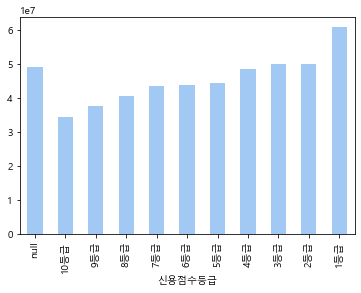

In [1117]:
sns.set_palette("pastel")
user_spec.groupby(['신용점수등급'])['연소득'].mean().plot.bar()

## 입사연월 전처리
- 입사년차 계산하여 column 생성
    - 입사연월이 없는 경우 -1로 처리
- 입사연월이 null인 경우는 모두 기타수입이나 사업자

In [1118]:
user_spec[user_spec['입사연월'].isnull()]['근로형태'].value_counts()

OTHERINCOME        83026
PRIVATEBUSINESS        3
EARNEDINCOME           2
Name: 근로형태, dtype: int64

5명의 입사연월을 각 유저의 생년월일, 성별이 동일한 유저들의 입사연월 중 최빈값으로 대체


In [1119]:
no_duplicated_user = user_spec.drop_duplicates(['유저_번호'])
user_list = list(user_spec[(user_spec['입사연월'].isnull())&(user_spec['근로형태']=='EARNEDINCOME')]['유저_번호'].index)+list(user_spec[(user_spec['입사연월'].isnull())&(user_spec['근로형태']=='PRIVATEBUSINESS')]['유저_번호'].index)
for i in user_list:
    user_spec.iloc[i,8] = no_duplicated_user[(no_duplicated_user['유저_생년월일']==user_spec.iloc[i,2])&(no_duplicated_user['유저_성별']==user_spec.iloc[i,3])]['입사연월'].mode()[0]

In [1120]:
#생성일시 datetime으로 변경
user_spec['생성일시_연월'] = user_spec['생성일시'].str[:7]
user_spec['생성일시_연월'] = user_spec['생성일시_연월'].str.replace(pat=r'[^\w]', repl=r'', regex=True)
user_spec['생성일시_연월'] = pd.to_datetime(user_spec['생성일시_연월'],format = '%Y%m')

In [1122]:
#입사연월 datetime으로 변경
user_spec['입사연월_연월'] = user_spec['입사연월'].astype(str).str[:6]
user_spec.loc[user_spec['입사연월_연월']=='nan','입사연월_연월'] = '202301'# nan값인 데이터들 처리
user_spec.loc[user_spec['입사연월'].isnull(),'입사연월'] = '202301'
user_spec['입사연월_연월'] = pd.to_datetime(user_spec['입사연월_연월'],format = '%Y%m')

In [1121]:
user_spec['근로형태'].value_counts()

EARNEDINCOME       617321
OTHERINCOME         83605
PRIVATEBUSINESS     72370
EARNEDINCOME2       56753
FREELANCER          52869
PRACTITIONER        14734
Name: 근로형태, dtype: int64

In [1127]:
user_spec[user_spec['입사연월_연월']=='2023-01-01']

,신청서_번호,유저_번호,유저_생년월일,유저_성별,생성일시,한도조회_당시_유저_신용점수,연소득,근로형태,입사연월,고용형태,...,대출희망금액,대출_목적,개인회생자_여부,개인회생자_납입_완료_여부,기대출수,기대출금액,대출비교횟수,신용점수등급,생성일시_연월,입사연월_연월
0,566528,681184,1974.0,1.0,2022-03-01 00:11:35,580.0,8000000.0,OTHERINCOME,202301,기타,...,1000000.0,생활비,NaN,NaN,4.0,20000000.0,38,8등급,2022-03-01,2023-01-01
14,38545,477093,1971.0,0.0,2022-03-01 00:14:14,650.0,40000000.0,OTHERINCOME,202301,기타,...,4000000.0,생활비,NaN,NaN,6.0,30000000.0,6,7등급,2022-03-01,2023-01-01
21,1641514,477093,1971.0,0.0,2022-03-01 00:16:46,650.0,40000000.0,OTHERINCOME,202301,기타,...,3000000.0,생활비,NaN,NaN,6.0,30000000.0,6,7등급,2022-03-01,2023-01-01
27,1799957,532198,1997.0,0.0,2022-03-01 00:18:35,710.0,20000000.0,OTHERINCOME,202301,기타,...,60000000.0,생활비,NaN,NaN,4.0,44000000.0,14,6등급,2022-03-01,2023-01-01
53,1947881,221044,1958.0,0.0,2022-03-01 00:25:54,700.0,10000000.0,OTHERINCOME,202301,기타,...,15000000.0,생활비,NaN,NaN,1.0,10000000.0,2,6등급,2022-03-01,2023-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897605,1619148,513009,1990.0,1.0,2022-06-30 23:41:14,550.0,30000000.0,OTHERINCOME,202301,기타,...,1000000.0,기타,0.0,NaN,5.0,56000000.0,6,8등급,2022-06-01,2023-01-01
897609,1785884,256063,1996.0,1.0,2022-06-30 23:42:02,750.0,0.0,OTHERINCOME,202301,기타,...,1000000.0,생활비,0.0,NaN,1.0,2000000.0,2,5등급,2022-06-01,2023-01-01
897617,464703,840464,1977.0,0.0,2022-06-30 23:43:45,660.0,25000000.0,OTHERINCOME,202301,기타,...,10000000.0,생활비,0.0,NaN,NaN,NaN,1,7등급,2022-06-01,2023-01-01
897628,179951,765301,1995.0,1.0,2022-06-30 23:46:26,590.0,20000000.0,OTHERINCOME,202301,기타,...,3000000.0,생활비,0.0,NaN,3.0,16000000.0,7,8등급,2022-06-01,2023-01-01


In [1123]:
user_spec[(user_spec['입사연월_연월']>'2022-04-01')&(user_spec['입사연월_연월']!='2023-01-01')&(~user_spec['근로형태'].isin(['FREELANCER','OTHERINCOME']))]

,신청서_번호,유저_번호,유저_생년월일,유저_성별,생성일시,한도조회_당시_유저_신용점수,연소득,근로형태,입사연월,고용형태,...,대출희망금액,대출_목적,개인회생자_여부,개인회생자_납입_완료_여부,기대출수,기대출금액,대출비교횟수,신용점수등급,생성일시_연월,입사연월_연월
425950,1797717,739830,1997.0,1.0,2022-05-01 06:36:48,710.0,12000000.0,EARNEDINCOME,202205,계약직,...,3000000.0,생활비,0.0,NaN,2.0,2000000.0,2,6등급,2022-05-01,2022-05-01
427482,2155289,469412,1958.0,0.0,2022-05-01 14:08:21,610.0,180000000.0,PRIVATEBUSINESS,202205,정규직,...,50000000.0,대환대출,0.0,0.0,NaN,NaN,1,7등급,2022-05-01,2022-05-01
429293,752139,607825,2002.0,1.0,2022-05-01 22:01:41,750.0,24000000.0,EARNEDINCOME2,202205,계약직,...,2000000.0,생활비,0.0,0.0,2.0,5000000.0,13,5등급,2022-05-01,2022-05-01
429435,174044,607825,2002.0,1.0,2022-05-01 22:42:05,750.0,24000000.0,EARNEDINCOME2,202205,계약직,...,3000000.0,생활비,0.0,0.0,2.0,5000000.0,13,5등급,2022-05-01,2022-05-01
429517,1978807,649302,1973.0,1.0,2022-05-01 23:06:35,690.0,25000000.0,EARNEDINCOME2,202205,정규직,...,10000000.0,대환대출,0.0,NaN,1.0,8000000.0,26,6등급,2022-05-01,2022-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897603,121701,195992,1985.0,0.0,2022-06-30 23:40:40,610.0,26000000.0,EARNEDINCOME,2.02206e+07,정규직,...,20000000.0,대환대출,0.0,NaN,3.0,21000000.0,7,7등급,2022-06-01,2022-06-01
897615,470149,760630,1993.0,0.0,2022-06-30 23:43:22,610.0,33000000.0,EARNEDINCOME,2.02205e+07,정규직,...,5000000.0,생활비,0.0,0.0,28.0,9000000.0,5,7등급,2022-06-01,2022-05-01
897635,2142202,65277,1993.0,1.0,2022-06-30 23:47:56,860.0,38000000.0,EARNEDINCOME,2.02206e+07,정규직,...,100000000.0,전월세보증금,0.0,NaN,NaN,NaN,1,3등급,2022-06-01,2022-06-01
897636,623769,436798,1992.0,1.0,2022-06-30 23:48:05,530.0,30000000.0,EARNEDINCOME2,2.02205e+07,계약직,...,1000000.0,생활비,0.0,NaN,6.0,13000000.0,31,8등급,2022-06-01,2022-05-01


입사연월이 유저의 생년월일보다 빠른 데이터
- 입사연월이 유저의 생년월일보다 빠른 데이터 중 test_data에 없는 데이터는 삭제
- 입사연월을 각 유저의 생년월일, 성별과 동일한 유저들의 입사연월 중 최빈값으로 대체



In [1129]:
user_spec['유저_생년월일'] = pd.to_datetime(user_spec['유저_생년월일'],format = '%Y') #유저 생년월일 datetime으로 변경
temp_list =set(user_spec[user_spec['유저_생년월일']>user_spec['입사연월_연월']]['신청서_번호'])#유저 생년월일이 입사연월보다 빠른 유저 리스트
loan_list = set(loan_result[(loan_result['신청_여부(y)'].isnull())&(loan_result['신청서_번호'].isin(temp_list))]['신청서_번호']) #test 데이터 중 유저 생년월일이 입사연월보다 빠른 유저 리스트
drop_list = temp_list-loan_list

user_spec.drop(user_spec[user_spec['신청서_번호'].isin(drop_list)].index,inplace=True)
user_spec.reset_index(drop = True,inplace = True)

In [1130]:
no_duplicated_user = user_spec.drop_duplicates(['유저_번호'])#중복되지 않은 유저들의 최빈값 사용하여 대체
temp = list(user_spec[user_spec['신청서_번호'].isin(loan_list)].index) #4명
for i in temp:
    user_spec.iloc[i,-1] = no_duplicated_user[(no_duplicated_user['유저_생년월일']==user_spec.iloc[i,2])&(no_duplicated_user['유저_성별']==user_spec.iloc[i,3])&(no_duplicated_user['근로형태']==user_spec.iloc[i,7])]['입사연월_연월'].mode()[0]

- 입사개월: 생성일시-입사연월  
- 입사나이: 입사연월-생년월일

In [1131]:
from datetime import datetime
def diff_month(x): # 입사개월 계산 함수
    return (x[0].year - x[1].year) * 12 + x[0].month - x[1].month 
def diff_year(x): # 입사년차 계산 함수
    return x[0].year - x[1].year

In [1133]:
user_spec['입사개월'] = user_spec[['생성일시_연월', '입사연월_연월']].apply(diff_month,axis=1)
user_spec.loc[user_spec['입사개월']<0,'입사개월'] = '-1'# 입사연월이 없는 otherincome 유저들은 -1로 mapping
user_spec['입사개월'] = user_spec['입사개월'].astype(int)
user_spec['입사나이'] = user_spec[['입사연월_연월','유저_생년월일']].apply(diff_year,axis =1)#입사나이
user_spec.loc[user_spec['입사개월']==-1,'입사나이']=-1#입사연월이 없는 사람들은 입사나이를 -1로 mapping

입사년차가 이상한 데이터
- 입사연월을 정확한 기준을 기점으로 그 이상이라면 위와 같이 처리 기준 논의....

## 연소득 전처리
1명이 해당되는데 기대출수가 있고 사업자금이 목적인 사람들의 평균 연소득으로 대체

In [1134]:
no_duplicated_user = user_spec.drop_duplicates(['유저_번호'])
user_spec.loc[user_spec[user_spec['연소득'].isnull()].index,'연소득']=no_duplicated_user[(no_duplicated_user['대출_목적']=='사업자금')&(no_duplicated_user['기대출수']>0)]['연소득'].mean()
user_spec.reset_index(drop =True,inplace = True)

## 개인회생자_여부,개인회생자_납입_완료_여부 전처리

In [1135]:
user_spec.groupby(['개인회생자_여부','개인회생자_납입_완료_여부']).size()

개인회생자_여부  개인회생자_납입_완료_여부
0.0       0.0               110988
          1.0                    2
1.0       0.0                 3953
          1.0                  586
dtype: int64

개인회생자 여부 0: 개인회생자X, 1: 개인회생자O

개인회생자 납입 완료 여부 0: (개인회생자인 경우) 납입중, 1: 납입완료



## 개인회생자_여부,개인회생자_납입_완료_여부 category
1) 개인회생자 X:0

2) 개인회생자 O
- 납입중:1
- 납입완료:2
    
3) 개인회생자 결측치

In [1136]:
user_spec.loc[(user_spec['개인회생자_여부']==0)&(user_spec['개인회생자_납입_완료_여부']==1),'개인회생자_납입_완료_여부']=0 # 개인회생자가 아니면서 납입완료된 유저는 3명 -> 완료여부 0으로 변경
user_spec.loc[(user_spec['개인회생자_여부']==0)&(user_spec['개인회생자_납입_완료_여부'].isnull()),'개인회생자_납입_완료_여부'] = 0

In [1137]:
user_spec['개인회생자'] = 10 #null값인 데이터는 처리 못한 상황
user_spec.loc[(user_spec['개인회생자_여부']==0)&(user_spec['개인회생자_납입_완료_여부']==0),'개인회생자'] = 0
user_spec.loc[(user_spec['개인회생자_여부']==1)&(user_spec['개인회생자_납입_완료_여부']==0),'개인회생자'] = 1
user_spec.loc[(user_spec['개인회생자_여부']==1)&(user_spec['개인회생자_납입_완료_여부']==1),'개인회생자'] = 2

In [1142]:
user_spec[user_spec['개인회생자']==10].head()

,신청서_번호,유저_번호,유저_생년월일,유저_성별,생성일시,한도조회_당시_유저_신용점수,연소득,근로형태,입사연월,고용형태,...,개인회생자_납입_완료_여부,기대출수,기대출금액,대출비교횟수,신용점수등급,생성일시_연월,입사연월_연월,입사개월,입사나이,개인회생자
0,566528,681184,1974-01-01,1.0,2022-03-01 00:11:35,580.0,8000000.0,OTHERINCOME,202301,기타,...,NaN,4.0,20000000.0,38,8등급,2022-03-01,2023-01-01,-1,-1.0,10
1,180433,623737,1997-01-01,1.0,2022-03-01 00:12:05,740.0,12000000.0,FREELANCER,202202,일용직,...,NaN,3.0,11000000.0,12,6등급,2022-03-01,2022-02-01,1,25.0,10
2,1657888,752985,1997-01-01,1.0,2022-03-01 00:12:06,580.0,12000000.0,FREELANCER,202102,기타,...,NaN,7.0,33000000.0,19,8등급,2022-03-01,2021-02-01,13,24.0,10
3,1875716,644882,1994-01-01,1.0,2022-03-01 00:12:29,610.0,35000000.0,FREELANCER,202107,기타,...,NaN,1.0,3000000.0,2,7등급,2022-03-01,2021-07-01,8,27.0,10
4,726394,596376,1989-01-01,1.0,2022-03-01 00:12:33,680.0,26000000.0,EARNEDINCOME,202111,정규직,...,NaN,2.0,38000000.0,3,6등급,2022-03-01,2021-11-01,4,32.0,10


## 기대출수, 기대출금액 전처리

In [846]:
temp = loan_result[(loan_result['신청_여부(y)']==1)&(loan_result['신청서_번호'].isin(list(user_spec[user_spec['개인회생자_여부']==1]['신청서_번호'])))]

In [850]:
temp.groupby(['금융사_번호','상품_번호']).size()

금융사_번호  상품_번호
1       61        58
2       93        27
        126      116
3       152        5
        205        9
                ... 
62      200       10
63      184       65
        226       56
64      245        1
        254       14
Length: 117, dtype: int64

In [1147]:
user_spec[(user_spec['입사나이']<15)&(user_spec['입사나이']>-1)&(user_spec['근로형태']=='EARNEDINCOME')]

,신청서_번호,유저_번호,유저_생년월일,유저_성별,생성일시,한도조회_당시_유저_신용점수,연소득,근로형태,입사연월,고용형태,...,개인회생자_납입_완료_여부,기대출수,기대출금액,대출비교횟수,신용점수등급,생성일시_연월,입사연월_연월,입사개월,입사나이,개인회생자
11815,758115,187040,1978-01-01,0.0,2022-03-02 19:27:02,600.0,160000000.0,EARNEDINCOME,199002,정규직,...,NaN,11.0,276000000.0,5,7등급,2022-03-01,1990-02-01,385,12.0,10
14395,1932765,484907,1996-01-01,0.0,2022-03-03 09:27:43,890.0,2000000.0,EARNEDINCOME,200005,정규직,...,NaN,1.0,19000000.0,5,2등급,2022-03-01,2000-05-01,262,4.0,10
26482,1213914,858138,1985-01-01,1.0,2022-03-04 18:18:31,700.0,100000000.0,EARNEDINCOME,199602,정규직,...,NaN,3.0,99000000.0,12,6등급,2022-03-01,1996-02-01,313,11.0,10
45763,136750,484907,1996-01-01,0.0,2022-03-08 10:37:23,720.0,2000000.0,EARNEDINCOME,200005,정규직,...,NaN,1.0,19000000.0,5,6등급,2022-03-01,2000-05-01,262,4.0,10
49533,1288800,790052,1999-01-01,1.0,2022-03-08 18:37:11,720.0,100000000.0,EARNEDINCOME,201203,정규직,...,NaN,NaN,NaN,4,6등급,2022-03-01,2012-03-01,120,13.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877535,1030707,551904,1988-01-01,0.0,2022-06-28 20:06:57,790.0,40000000.0,EARNEDINCOME,1.98809e+07,정규직,...,0.0,1.0,37000000.0,2,5등급,2022-06-01,1988-09-01,405,0.0,0
881562,1551584,746831,1997-01-01,0.0,2022-06-29 10:41:15,810.0,36000000.0,EARNEDINCOME,1.99703e+07,정규직,...,0.0,2.0,17000000.0,5,4등급,2022-06-01,1997-03-01,303,0.0,0
884091,142390,288088,1988-01-01,1.0,2022-06-29 14:26:49,710.0,60000000.0,EARNEDINCOME,1.9881e+07,정규직,...,0.0,1.0,47000000.0,5,6등급,2022-06-01,1988-10-01,404,0.0,0
890336,1413225,132008,1966-01-01,1.0,2022-06-30 10:12:48,750.0,85000000.0,EARNEDINCOME,1.96603e+07,정규직,...,0.0,4.0,381000000.0,1,5등급,2022-06-01,1966-03-01,675,0.0,0


기대출수가 +1이 되는지 확인

In [1154]:
loan_list = set(loan_result[loan_result['신청_여부(y)']==1]['신청서_번호'])
len(loan_list)

377506

In [1192]:
loan_result.groupby(['신청서_번호','신청_여부(y)']).size()

신청서_번호   신청_여부(y)
1        0.0          6
2        0.0          1
6        0.0         15
14       0.0          8
         1.0          3
                     ..
2167819  0.0          3
2167820  0.0          6
         1.0          1
2167826  0.0          4
         1.0          1
Length: 1036105, dtype: int64

대출상품마다 승인한도와 승인금리를 통한 비율로 납부금액을 계산

In [1172]:
loan_result['납부금액'] = (loan_result['승인한도']*loan_result['승인금리'])/100

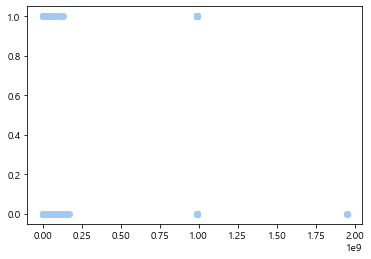

In [1181]:
import matplotlib.pylab as plt
plt.scatter(loan_result[loan_result['신청_여부(y)'].notnull()]['납부금액'],loan_result[loan_result['신청_여부(y)'].notnull()]['신청_여부(y)'])
plt.show()

In [1186]:
user_spec[user_spec['대출희망금액']==0]

,신청서_번호,유저_번호,유저_생년월일,유저_성별,생성일시,한도조회_당시_유저_신용점수,연소득,근로형태,입사연월,고용형태,...,개인회생자_납입_완료_여부,기대출수,기대출금액,대출비교횟수,신용점수등급,생성일시_연월,입사연월_연월,입사개월,입사나이,개인회생자
211,682872,109911,1999-01-01,1.0,2022-03-01 01:28:16,750.0,20000000.0,EARNEDINCOME,202201,계약직,...,NaN,1.0,NaN,15,5등급,2022-03-01,2022-01-01,2,23.0,10
1371,530718,51912,1982-01-01,0.0,2022-03-01 10:39:23,770.0,22000000.0,EARNEDINCOME,201703,정규직,...,NaN,10.0,73000000.0,2,5등급,2022-03-01,2017-03-01,60,35.0,10
1709,614699,52133,2001-01-01,1.0,2022-03-01 11:42:32,740.0,2000000.0,EARNEDINCOME,202203,계약직,...,NaN,1.0,2000000.0,1,6등급,2022-03-01,2022-03-01,0,21.0,10
2366,1466542,294023,1994-01-01,0.0,2022-03-01 13:39:10,670.0,27000000.0,EARNEDINCOME,202007,정규직,...,NaN,10.0,17000000.0,42,6등급,2022-03-01,2020-07-01,20,26.0,10
2907,757825,601592,1992-01-01,1.0,2022-03-01 15:19:25,820.0,30000000.0,OTHERINCOME,202301,기타,...,NaN,2.0,40000000.0,8,4등급,2022-03-01,2023-01-01,-1,-1.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895275,887540,845842,1976-01-01,1.0,2022-06-30 17:20:06,960.0,1000000.0,OTHERINCOME,202301,기타,...,0.0,NaN,NaN,1,1등급,2022-06-01,2023-01-01,-1,-1.0,0
895336,1417456,391550,1976-01-01,1.0,2022-06-30 17:26:40,960.0,40000000.0,EARNEDINCOME,2.01502e+07,정규직,...,0.0,1.0,NaN,1,1등급,2022-06-01,2015-02-01,88,39.0,0
897000,1792336,225822,1977-01-01,1.0,2022-06-30 21:37:44,950.0,150000000.0,EARNEDINCOME,2.0211e+07,정규직,...,0.0,3.0,545000000.0,23,1등급,2022-06-01,2021-10-01,8,44.0,0
897217,893416,315101,1996-01-01,0.0,2022-06-30 22:16:55,720.0,0.0,OTHERINCOME,202301,기타,...,0.0,4.0,31000000.0,2,6등급,2022-06-01,2023-01-01,-1,-1.0,0
